In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/home/maarten/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def G_loop(cell):

    for g in range(G):
        
        #G -> G interactions
        Ginteract = np.dot(Gstate.T[cell], A1[g])
        
        #H -> G interactions (based on previous and next cell c-1, c+1)
        #boundary conditions (for cell 1 take only H values from cell 2, and from cell C only from C-1)
        if cell == 0:
            Ginteract += np.dot(Hstate.T[1], A2[g])
        elif cell == C-1:
            Ginteract += np.dot(Hstate.T[cell-1], A2[g])            
        else:
            Ginteract += np.dot(np.where(Hstate.T[cell-1] + Hstate.T[cell+1] > 0, 1, 0), A2[g])
        
        
        #Assign values to new generation by using Theta function
        if Ginteract > 0:
            Gcopy[g, cell] = 1
        else:
            Gcopy[g, cell] = 0
            
def H_loop(cell):
            
    for h in range(H):

        #G -> H interactions
        Hinteract = np.dot(Gstate.T[cell], B[h])

        #Assign values to new generation by using Theta function
        if Hinteract > 0:
            Hcopy[h,cell] = 1
        else:
            Hcopy[h,cell] = 0       

def Cycle():
    #loop start boundary conditions
    G_loop(0)
    H_loop(0)


    # There have to be 3 or more cells for this loop to work
    for c in range(1, C-1):    #loop over all but first and last cell

        G_loop(c)
        H_loop(c)


    #loop final boundary conditions
    G_loop(C-1)
    H_loop(C-1)

#     print('next')
#     print(np.vstack((Gcopy, Hcopy)))

#     sns.heatmap(np.vstack((Gstate, Hstate)))
#     plt.show()

def adaptive_step():

    global A1
    
    adaption = np.random.choice([0,1,2])
    
    row_index = np.random.randint(0, G)  
    col_index = np.random.randint(0, G) 
        
    if adaption == 0: #removal
        A1[row_index, col_index] = 0
    elif adaption == 1: #addition
        A1[row_index, col_index] = 1
    elif adaption == 2: #randomization
        A1[row_index, col_index] = np.random.uniform(-1, 1)


def Organism(Gmatrix, Hmatrix):
    return np.vstack((Gmatrix, Hmatrix))

#fitness is computed by counting the number of distinct cells
def Fitness(organism):
    return len(set(tuple(r) for r in organism.T))

def initialize_links():

    #matrix containing all intergenomic interactions (GxG)
    global A1_initial
#     A1_initial = np.random.uniform(-1,1, size=(G, G))
#     with open('A1.pkl', 'wb') as f:
#         pickle.dump(A1_initial, f)
        
    #uncomment if link matrices are needed when continuing with the same run
    with open('A1.pkl', 'rb') as f:
        A1_initial = pickle.load(f)
    
    #matrix containing all interactions from H to G (HxG)
    global A2_initial
#     A2_initial = np.random.uniform(-1,1, size=(G, H))
#     with open('A2.pkl', 'wb') as f:
#         pickle.dump(A2_initial, f)
    
    
    #uncomment if link matrices are needed when continuing with the same run
    with open('A2.pkl', 'rb') as f:
        A2_initial = pickle.load(f)
    
    #matrix containing all interactions from G to H (GxH)
    global B_initial
#     B_initial = np.random.uniform(-1,1, size=(H, G))
#     with open('B.pkl', 'wb') as f:
#         pickle.dump(B_initial, f)
    
    #uncomment if link matrices are needed when continuing with the same run
    with open('B.pkl', 'rb') as f:
        B_initial = pickle.load(f)
    
def initialize_states():
    global Gstate_initial
    Gstate_initial = np.zeros((G,C))
    Gstate_initial[0,0] = 1
    global Hstate_initial
    Hstate_initial = np.zeros((H,C))
    
def reinitialize():
    initialize_links()
    initialize_states()


In [4]:
#number of cells in organism
C = 15

#genes
G = 3

#hormones
H = 2

N = G + H

#number of cycle iterations in which the pattern has te become stable
I = 100

#number of individual organisms in population
P = 500

#number of generations per organism
Generations = 15000

#initialize both the links and the states of the cells

initialize_links()
initialize_states()

In [ ]:
#initial state has two types of cells


# with open('stable_patterns.pkl', 'rb') as f:
#     stable_patterns = pickle.load(f)

for p in range(P):
    
    stable_patterns = [[]]*Generations
    
    #copy of link matrices that will be randomly altered during each step in the generations loop

    A1 = np.copy(A1_initial)
    A2 = np.copy(A2_initial)
    B = np.copy(B_initial) 
    
    nct = 2
    nct_list = []

    for j in range(Generations):
        
        #copy of states to compute new values with and compare afterwards
        Gstate = np.copy(Gstate_initial)
        Hstate = np.copy(Hstate_initial)

        #copy A1 to compare afterwards based on fitness (number of cells nct)
        A1copy = np.copy(A1)

        #perform single adaptive walk step on A1 matrix
        adaptive_step()

        #boolean to check if the pattern has become stable or not
        stable = False

        for i in range(I):
            
            #copy of states to compute new values with and compare afterwards
            Gcopy = np.copy(Gstate)
            Hcopy = np.copy(Hstate)

            Cycle()
            
            #if the pattern is the same as that of the last cycle it is stable
            if np.allclose(Gstate, Gcopy) and np.allclose(Hstate, Hcopy):
                stable = True
                break

            #reassign new state for next cycle
            Gstate = np.copy(Gcopy)
            Hstate = np.copy(Hcopy)

        #do not add pattern to stable_patterns
        if not stable:
            A1 = np.copy(A1copy)
            
        else:
            pattern = Organism(Gstate, Hstate)
            fit = Fitness(pattern)
            #if newly computed fitness is smaller than earlier one, keep old A1 matrix
            if fit < nct:
                A1 = np.copy(A1copy)
            #otherwise stay with A1 and use new fitness as new measure
            else:
                nct = fit
                
            stable_patterns[j].append(tuple(pattern.flatten()))

    with open('stable_patterns.pkl', 'ab') as f:
        pickle.dump(stable_patterns, f)
    print(p)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [15]:
from collections import Counter

for stable in stable_patterns:
    cdict = Counter(stable)
    print(cdict.values())

dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])
dict_values([666, 61, 5, 1, 7, 8])


In [25]:
k = []
c = 0
for i in stable_patterns:
#     for j in i:
#         print(list(j.flatten()))
    k.append(len(set([tuple(j.flatten()) for j in i])))
    c+=1
    print(c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


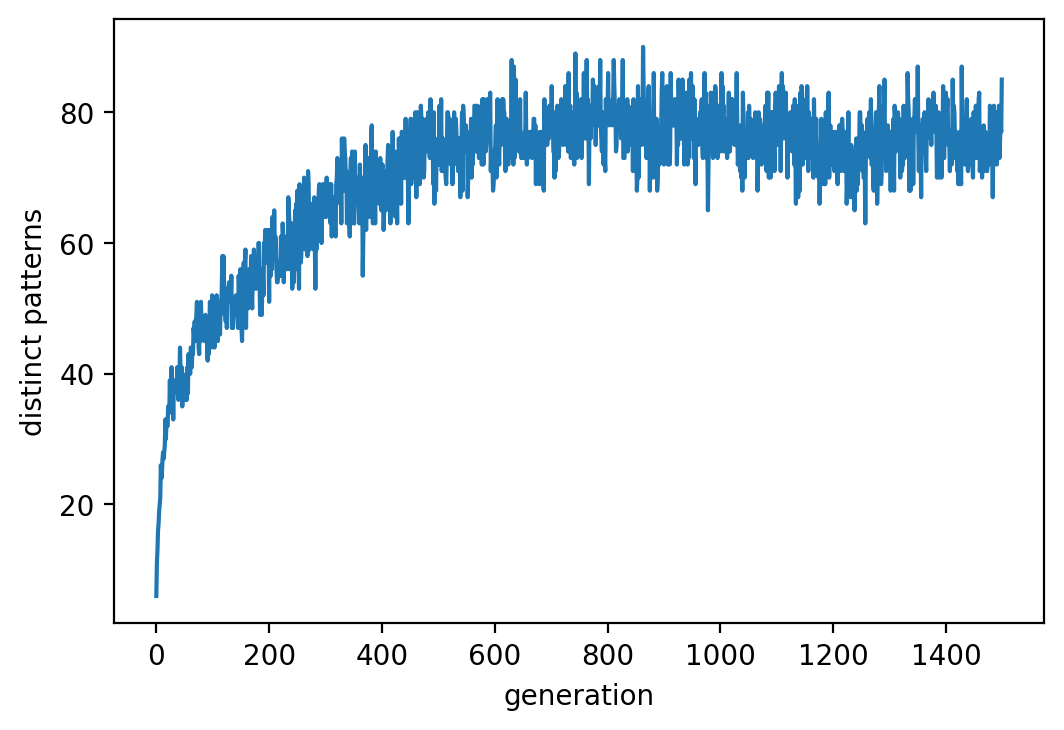

In [26]:
plt.figure(dpi=200)
plt.plot(k)
plt.xlabel('generation')
plt.ylabel('distinct patterns')
plt.savefig('indicatie.png')

In [24]:
import pickle
with open('C8_C3_H2_patterns.pickle', 'wb') as handle:
    pickle.dump(k, handle)
